# **MITRE ATT&CK PYTHON CLIENT**: Data Sources
------------------

## Goals:
* Access ATT&CK data sources in STIX format via a public TAXII server
* Learn to interact with ATT&CK data all at once
* Explore and idenfity patterns in the data retrieved
* Learn more about ATT&CK data sources

## 1. ATT&CK Python Client Installation

You can install it via PIP: **pip install attackcti**

## 2. Import ATT&CK API Client

In [1]:
from attackcti import attack_client

## 3. Import Extra Libraries

In [2]:
from pandas import *
from pandas.io.json import json_normalize

import numpy as np

import altair as alt
alt.renderers.enable('default')

import itertools


## 4. Initialize ATT&CK Client Class

In [3]:
lift = attack_client()

## 5. Getting Information About Techniques

Getting ALL ATT&CK Techniques

In [4]:
all_techniques = lift.get_all_techniques()

Showing the first technique in our list

In [5]:
all_techniques[0]

{'type': 'attack-pattern',
 'id': 'attack-pattern--65917ae0-b854-4139-83fe-bf2441cf0196',
 'created_by_ref': 'identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5',
 'created': '2018-10-17 00:14:20.652000+00:00',
 'modified': '2018-10-31 13:45:13.024000+00:00',
 'object_marking_refs': ['marking-definition--fa42a846-8d90-4e51-bc29-71d5b4802168'],
 'url': 'https://attack.mitre.org/techniques/T1222',
 'matrix': 'mitre-attack',
 'technique': 'File Permissions Modification',
 'technique_description': "File permissions are commonly managed by discretionary access control lists (DACLs) specified by the file owner. File DACL implementation may vary by platform, but generally explicitly designate which users/groups can perform which actions (ex: read, write, execute, etc.). (Citation: Microsoft DACL May 2018) (Citation: Microsoft File Rights May 2018) (Citation: Unix File Permissions)\n\nAdversaries may modify file permissions/attributes to evade intended DACLs. (Citation: Hybrid Analysis Icacls1 Jun

Normalizing semi-structured JSON data into a flat table via **pandas.io.json.json_normalize**
* Reference: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html

In [6]:
techniques_normalized = json_normalize(all_techniques)

In [7]:
techniques_normalized[0:1]

,capec_id,capec_url,contributors,created,created_by_ref,data_sources,defense_bypassed,detectable_by_common_defenses,detectable_explanation,difficulty_explanation,...,system_requirements,tactic,tactic_type,technique,technique_description,technique_detection,technique_id,technique_references,type,url
0,None,None,"[Jan Miller, CrowdStrike]",2018-10-17 00:14:20.652000+00:00,identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5,"[File monitoring, Process monitoring, Process ...",[File system access controls],None,None,None,...,None,[defense-evasion],None,File Permissions Modification,File permissions are commonly managed by discr...,Monitor and investigate attempts to modify DAC...,T1222,"[https://attack.mitre.org/techniques/T1222, ht...",attack-pattern,https://attack.mitre.org/techniques/T1222


## 6. Re-indexing Dataframe

In [8]:
techniques = techniques_normalized.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

In [9]:
techniques.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,"[Linux, Windows, macOS]",[defense-evasion],File Permissions Modification,T1222,"[File monitoring, Process monitoring, Process ..."
1,mitre-attack,[Windows],"[defense-evasion, execution]",Compiled HTML File,T1223,"[File monitoring, Process monitoring, Process ..."
2,mitre-attack,[Windows],[defense-evasion],Template Injection,T1221,"[Anti-virus, Email gateway, Network intrusion ..."
3,mitre-attack,[Windows],"[defense-evasion, execution]",XSL Script Processing,T1220,"[Process monitoring, Process command-line para..."
4,mitre-attack,[Windows],"[defense-evasion, persistence]",BITS Jobs,T1197,"[API monitoring, Packet capture, Windows event..."


In [10]:
print('A total of ',len(techniques),' techniques')

A total of  478  techniques


## 7. Techniques With and Without Data Sources

Using **altair** python library we can start showing a few charts stacking the number of techniques with or without data sources.
Reference: https://altair-viz.github.io/

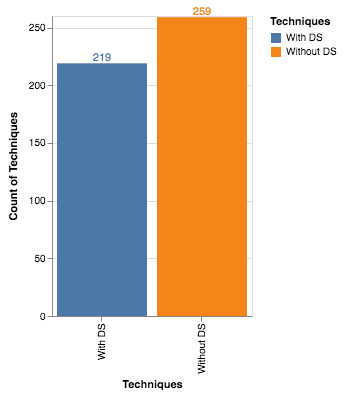

In [11]:
data_source_distribution = pandas.DataFrame({
    'Techniques': ['Without DS','With DS'],
    'Count of Techniques': [techniques['data_sources'].isna().sum(),techniques['data_sources'].notna().sum()]})
bars = alt.Chart(data_source_distribution).mark_bar().encode(x='Techniques',y='Count of Techniques',color='Techniques').properties(width=200,height=300)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

What is the distribution of techniques based on ATT&CK Matrix?

In [12]:
data = techniques
data['Num_Tech'] = 1
data['Count_DS'] = data['data_sources'].str.len()
data['Ind_DS'] = np.where(data['Count_DS']>0,'With DS','Without DS')
data_2 = data.groupby(['matrix','Ind_DS'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,Ind_DS,technique
0,mitre-attack,With DS,219
1,mitre-attack,Without DS,4
2,mitre-mobile-attack,Without DS,81
3,mitre-pre-attack,Without DS,174


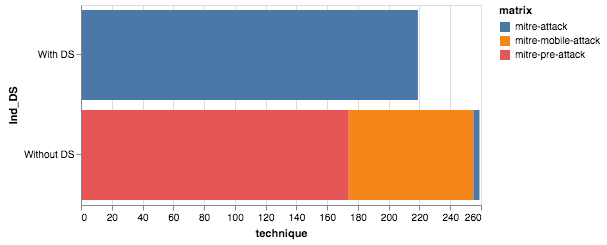

In [13]:
alt.Chart(data_3).mark_bar().encode(x='technique', y='Ind_DS', color='matrix').properties(height = 200)

What are those mitre-attack techniques without data sources?

In [14]:
data[(data['matrix']=='mitre-attack') & (data['Ind_DS']=='Without DS')]

,matrix,platform,tactic,technique,technique_id,data_sources,Num_Tech,Count_DS,Ind_DS
20,mitre-attack,"[Linux, macOS]","[defense-evasion, persistence, command-and-con...",Port Knocking,T1205,None,1,NaN,Without DS
61,mitre-attack,[macOS],[defense-evasion],Gatekeeper Bypass,T1144,None,1,NaN,Without DS
81,mitre-attack,[macOS],[persistence],Re-opened Applications,T1164,None,1,NaN,Without DS
103,mitre-attack,[Windows],[discovery],Peripheral Device Discovery,T1120,None,1,NaN,Without DS


### Techniques without data sources

In [15]:
techniques_without_data_sources=techniques[techniques.data_sources.isnull()].reset_index(drop=True)

In [16]:
techniques_without_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Num_Tech,Count_DS,Ind_DS
0,mitre-attack,"[Linux, macOS]","[defense-evasion, persistence, command-and-con...",Port Knocking,T1205,None,1,NaN,Without DS
1,mitre-attack,[macOS],[defense-evasion],Gatekeeper Bypass,T1144,None,1,NaN,Without DS
2,mitre-attack,[macOS],[persistence],Re-opened Applications,T1164,None,1,NaN,Without DS
3,mitre-attack,[Windows],[discovery],Peripheral Device Discovery,T1120,None,1,NaN,Without DS
4,mitre-pre-attack,None,[technical-information-gathering],Spearphishing for Information,T1397,None,1,NaN,Without DS


In [17]:
print('There are ',techniques['data_sources'].isna().sum(),' techniques without data sources (',"{0:.0%}".format(techniques['data_sources'].isna().sum()/len(techniques)),' of ',len(techniques),' techniques)')

There are  259  techniques without data sources ( 54%  of  478  techniques)


### Techniques With Data Sources

In [18]:
techniques_with_data_sources=techniques[techniques.data_sources.notnull()].reset_index(drop=True)

In [19]:
techniques_with_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Num_Tech,Count_DS,Ind_DS
0,mitre-attack,"[Linux, Windows, macOS]",[defense-evasion],File Permissions Modification,T1222,"[File monitoring, Process monitoring, Process ...",1,4.0,With DS
1,mitre-attack,[Windows],"[defense-evasion, execution]",Compiled HTML File,T1223,"[File monitoring, Process monitoring, Process ...",1,3.0,With DS
2,mitre-attack,[Windows],[defense-evasion],Template Injection,T1221,"[Anti-virus, Email gateway, Network intrusion ...",1,4.0,With DS
3,mitre-attack,[Windows],"[defense-evasion, execution]",XSL Script Processing,T1220,"[Process monitoring, Process command-line para...",1,4.0,With DS
4,mitre-attack,[Windows],"[defense-evasion, persistence]",BITS Jobs,T1197,"[API monitoring, Packet capture, Windows event...",1,3.0,With DS


In [20]:
print('There are ',techniques['data_sources'].notna().sum(),' techniques with data sources (',"{0:.0%}".format(techniques['data_sources'].notna().sum()/len(techniques)),' of ',len(techniques),' techniques)')

There are  219  techniques with data sources ( 46%  of  478  techniques)


## 8. Grouping Techniques With Data Sources By Matrix

Let's create a graph to represent the number of techniques per matrix:

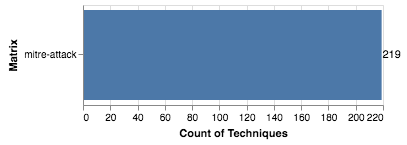

In [21]:
matrix_distribution = pandas.DataFrame({
    'Matrix': list(techniques_with_data_sources.groupby(['matrix'])['matrix'].count().keys()),
    'Count of Techniques': techniques_with_data_sources.groupby(['matrix'])['matrix'].count().tolist()})
bars = alt.Chart(matrix_distribution).mark_bar().encode(y='Matrix',x='Count of Techniques').properties(width=300,height=100)
text = bars.mark_text(align='center',baseline='middle',dx=10,dy=0).encode(text='Count of Techniques')
bars + text

All the techniques belong to **mitre-attack** matrix which is the main **Enterprise** matrix. Reference: https://attack.mitre.org/wiki/Main_Page 

## 9. Grouping Techniques With Data Sources by Platform

First, we need to split the **platform** column values because a technique might be mapped to more than one platform

In [22]:
techniques_platform=techniques_with_data_sources

attributes_1 = ['platform'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_1:
    s = techniques_platform.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_platform=techniques_platform.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_platform", and then join "techniques_platform" with "s"

# Let's re-arrange the columns from general to specific
techniques_platform_2=techniques_platform.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

We can now show techniques with data sources mapped to one platform at the time

In [23]:
techniques_platform_2.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,Linux,[defense-evasion],File Permissions Modification,T1222,"[File monitoring, Process monitoring, Process ..."
1,mitre-attack,Windows,[defense-evasion],File Permissions Modification,T1222,"[File monitoring, Process monitoring, Process ..."
2,mitre-attack,macOS,[defense-evasion],File Permissions Modification,T1222,"[File monitoring, Process monitoring, Process ..."
3,mitre-attack,Windows,"[defense-evasion, execution]",Compiled HTML File,T1223,"[File monitoring, Process monitoring, Process ..."
4,mitre-attack,Windows,[defense-evasion],Template Injection,T1221,"[Anti-virus, Email gateway, Network intrusion ..."


Let's create a visualization to show the number of techniques grouped by platform:

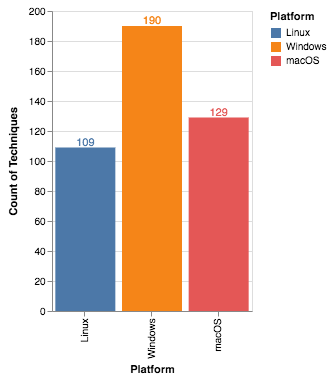

In [24]:
platform_distribution = pandas.DataFrame({
    'Platform': list(techniques_platform_2.groupby(['platform'])['platform'].count().keys()),
    'Count of Techniques': techniques_platform_2.groupby(['platform'])['platform'].count().tolist()})
bars = alt.Chart(platform_distribution,height=300).mark_bar().encode(x ='Platform',y='Count of Techniques',color='Platform').properties(width=200)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

In the bar chart above we can see that there are more techniques with data sources mapped to the Windows platform.

## 10. Grouping Techniques With Data Sources by Tactic

Again, first we need to split the tactic column values because a technique might be mapped to more than one tactic:

In [25]:
techniques_tactic=techniques_with_data_sources

attributes_2 = ['tactic'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_2:
    s = techniques_tactic.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_tactic = techniques_tactic.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_tactic", and then join "techniques_tactic" with "s"

# Let's re-arrange the columns from general to specific
techniques_tactic_2=techniques_tactic.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)


We can now show techniques with data sources mapped to one tactic at the time

In [26]:
techniques_tactic_2.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,"[Linux, Windows, macOS]",defense-evasion,File Permissions Modification,T1222,"[File monitoring, Process monitoring, Process ..."
1,mitre-attack,[Windows],defense-evasion,Compiled HTML File,T1223,"[File monitoring, Process monitoring, Process ..."
2,mitre-attack,[Windows],execution,Compiled HTML File,T1223,"[File monitoring, Process monitoring, Process ..."
3,mitre-attack,[Windows],defense-evasion,Template Injection,T1221,"[Anti-virus, Email gateway, Network intrusion ..."
4,mitre-attack,[Windows],defense-evasion,XSL Script Processing,T1220,"[Process monitoring, Process command-line para..."


Let's create a visualization to show the number of techniques grouped by tactic:

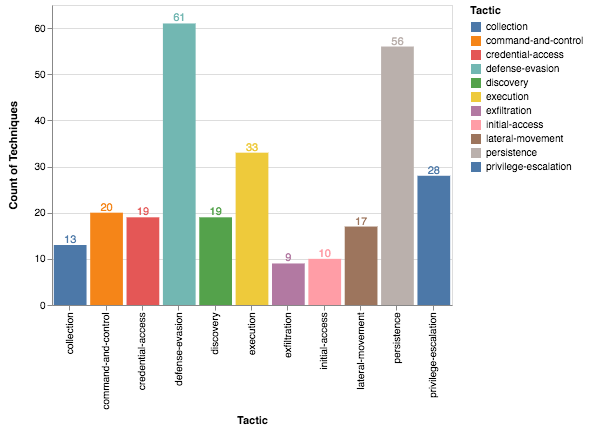

In [27]:
tactic_distribution = pandas.DataFrame({
    'Tactic': list(techniques_tactic_2.groupby(['tactic'])['tactic'].count().keys()),
    'Count of Techniques': techniques_tactic_2.groupby(['tactic'])['tactic'].count().tolist()}).sort_values(by='Count of Techniques',ascending=True)
bars = alt.Chart(tactic_distribution,width=800,height=300).mark_bar().encode(x ='Tactic',y='Count of Techniques',color='Tactic').properties(width=400)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

Defende-evasion and Persistence are tactics with the highest nummber of techniques with data sources

## 11. Grouping Techniques With Data Sources by Data Source

We need to split the data source column values because a technique might be mapped to more than one data source:

In [28]:
techniques_data_source=techniques_with_data_sources

attributes_3 = ['data_sources'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_3:
    s = techniques_data_source.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_data_source = techniques_data_source.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_data_source", and then join "techniques_data_source" with "s"

# Let's re-arrange the columns from general to specific
techniques_data_source_2 = techniques_data_source.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

# We are going to edit some names inside the dataframe to improve the consistency:
techniques_data_source_3 = techniques_data_source_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])

We can now show techniques with data sources mapped to one data source at the time

In [29]:
techniques_data_source_3.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,"[Linux, Windows, macOS]",[defense-evasion],File Permissions Modification,T1222,File monitoring
1,mitre-attack,"[Linux, Windows, macOS]",[defense-evasion],File Permissions Modification,T1222,Process Monitoring
2,mitre-attack,"[Linux, Windows, macOS]",[defense-evasion],File Permissions Modification,T1222,Process command-line parameters
3,mitre-attack,"[Linux, Windows, macOS]",[defense-evasion],File Permissions Modification,T1222,Windows event logs
4,mitre-attack,[Windows],"[defense-evasion, execution]",Compiled HTML File,T1223,File monitoring


Let's create a visualization to show the number of techniques grouped by data sources:

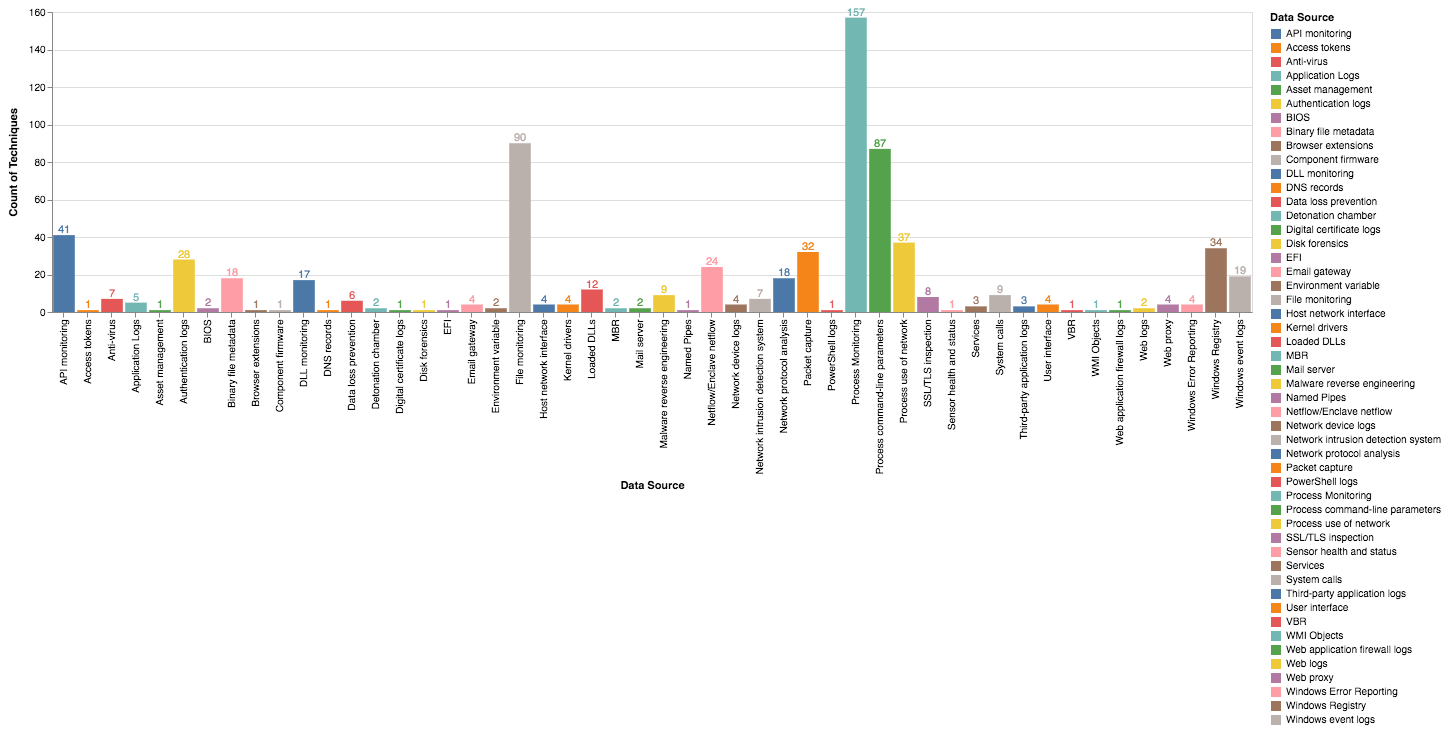

In [30]:
data_source_distribution = pandas.DataFrame({
    'Data Source': list(techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().keys()),
    'Count of Techniques': techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().tolist()})
bars = alt.Chart(data_source_distribution,width=800,height=300).mark_bar().encode(x ='Data Source',y='Count of Techniques',color='Data Source').properties(width=1200)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

A few interesting things from the bar chart above:
* Process Monitoring, File Monitoring, and Process Command-line parameters are the Data Sources with the highest number of techniques
* There are some data source names that include string references to Windows such as PowerShell, Windows and wmi

## 12. Most Relevant Groups Of Data Sources Per Technique

### Number Of Data Sources Per Technique

Although identifying the data sources with the highest number of techniques is a good start, they usually do not work alone. You might be collecting **Process Monitoring** already but you might be still missing a lot of context from a data perspective.

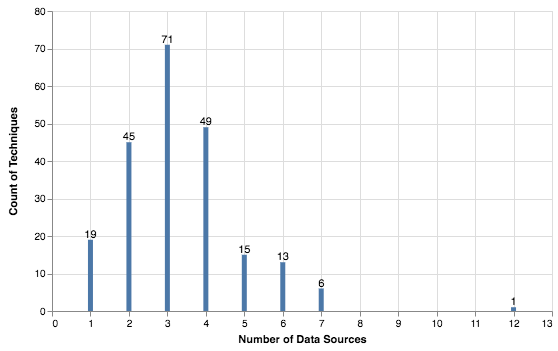

In [31]:
data_source_distribution_2 = pandas.DataFrame({
    'Techniques': list(techniques_data_source_3.groupby(['technique'])['technique'].count().keys()),
    'Count of Data Sources': techniques_data_source_3.groupby(['technique'])['technique'].count().tolist()})

data_source_distribution_3 = pandas.DataFrame({
    'Number of Data Sources': list(data_source_distribution_2.groupby(['Count of Data Sources'])['Count of Data Sources'].count().keys()),
    'Count of Techniques': data_source_distribution_2.groupby(['Count of Data Sources'])['Count of Data Sources'].count().tolist()})

bars = alt.Chart(data_source_distribution_3).mark_bar().encode(x ='Number of Data Sources',y='Count of Techniques').properties(width=500)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

The image above shows you the number data sources needed per techniques according to ATT&CK:
* There are 71 techniques that require 3 data sources as enough context to validate the detection of them according to ATT&CK
* Only one technique has 12 data sources
* One data source only applies to 19 techniques

Let's create subsets of data sources with the data source column defining and using a python function:

In [32]:
# https://stackoverflow.com/questions/26332412/python-recursive-function-to-display-all-subsets-of-given-set
def subs(l):
    res = []
    for i in range(1, len(l) + 1):
        for combo in itertools.combinations(l, i):
            res.append(list(combo))
    return res

Before applying the function, we need to use lowercase data sources names and sort data sources names to improve consistency:

In [33]:
df = techniques_with_data_sources[['data_sources']]

In [34]:
for index, row in df.iterrows():
    row["data_sources"]=[x.lower() for x in row["data_sources"]]
    row["data_sources"].sort()

In [35]:
df.head()

,data_sources
0,"[file monitoring, process command-line paramet..."
1,"[file monitoring, process command-line paramet..."
2,"[anti-virus, email gateway, network intrusion ..."
3,"[dll monitoring, process command-line paramete..."
4,"[api monitoring, packet capture, windows event..."


Let's apply the function and split the subsets column:

In [36]:
df['subsets']=df['data_sources'].apply(subs)

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
df.head()

,data_sources,subsets
0,"[file monitoring, process command-line paramet...","[[file monitoring], [process command-line para..."
1,"[file monitoring, process command-line paramet...","[[file monitoring], [process command-line para..."
2,"[anti-virus, email gateway, network intrusion ...","[[anti-virus], [email gateway], [network intru..."
3,"[dll monitoring, process command-line paramete...","[[dll monitoring], [process command-line param..."
4,"[api monitoring, packet capture, windows event...","[[api monitoring], [packet capture], [windows ..."


We need to split the subsets column values:

In [38]:
techniques_with_data_sources_preview = df

In [39]:
attributes_4 = ['subsets']

for a in attributes_4:
    s = techniques_with_data_sources_preview.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    s.name = a
    techniques_with_data_sources_preview = techniques_with_data_sources_preview.drop(a, axis=1).join(s).reset_index(drop=True)
    
techniques_with_data_sources_subsets = techniques_with_data_sources_preview.reindex(['data_sources','subsets'], axis=1)


In [40]:
techniques_with_data_sources_subsets.head()

,data_sources,subsets
0,"[file monitoring, process command-line paramet...",[file monitoring]
1,"[file monitoring, process command-line paramet...",[process command-line parameters]
2,"[file monitoring, process command-line paramet...",[process monitoring]
3,"[file monitoring, process command-line paramet...",[windows event logs]
4,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet..."


Let's add three columns to analyse the dataframe: subsets_name (Changing Lists to Strings), subsets_number_elements ( Number of data sources per subset) and number_data_sources_per_technique

In [41]:
techniques_with_data_sources_subsets['subsets_name']=techniques_with_data_sources_subsets['subsets'].apply(lambda x: ','.join(map(str, x)))
techniques_with_data_sources_subsets['subsets_number_elements']=techniques_with_data_sources_subsets['subsets'].str.len()
techniques_with_data_sources_subsets['number_data_sources_per_technique']=techniques_with_data_sources_subsets['data_sources'].str.len()

In [42]:
techniques_with_data_sources_subsets.head()

,data_sources,subsets,subsets_name,subsets_number_elements,number_data_sources_per_technique
0,"[file monitoring, process command-line paramet...",[file monitoring],file monitoring,1,4
1,"[file monitoring, process command-line paramet...",[process command-line parameters],process command-line parameters,1,4
2,"[file monitoring, process command-line paramet...",[process monitoring],process monitoring,1,4
3,"[file monitoring, process command-line paramet...",[windows event logs],windows event logs,1,4
4,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet...","file monitoring,process command-line parameters",2,4


As it was described above, we need to find grups pf data sources, so we are going to filter out all the subsets with only one data source:

In [43]:
subsets = techniques_with_data_sources_subsets

subsets_ok=subsets[subsets.subsets_number_elements != 1]

In [44]:
subsets_ok.head()

,data_sources,subsets,subsets_name,subsets_number_elements,number_data_sources_per_technique
4,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet...","file monitoring,process command-line parameters",2,4
5,"[file monitoring, process command-line paramet...","[file monitoring, process monitoring]","file monitoring,process monitoring",2,4
6,"[file monitoring, process command-line paramet...","[file monitoring, windows event logs]","file monitoring,windows event logs",2,4
7,"[file monitoring, process command-line paramet...","[process command-line parameters, process moni...","process command-line parameters,process monito...",2,4
8,"[file monitoring, process command-line paramet...","[process command-line parameters, windows even...","process command-line parameters,windows event ...",2,4


Finally, we calculate the most relevant groups of data sources (Top 15):

In [45]:
subsets_graph = subsets_ok.groupby(['subsets_name'])['subsets_name'].count().to_frame(name='subsets_count').sort_values(by='subsets_count',ascending=False)[0:15]

In [46]:
subsets_graph

,subsets_count
subsets_name,
"process command-line parameters,process monitoring",78
"file monitoring,process monitoring",68
"file monitoring,process command-line parameters",44
"file monitoring,process command-line parameters,process monitoring",37
"process monitoring,process use of network",32
"api monitoring,process monitoring",30
"process monitoring,windows registry",27
"packet capture,process use of network",20
"packet capture,process monitoring",19


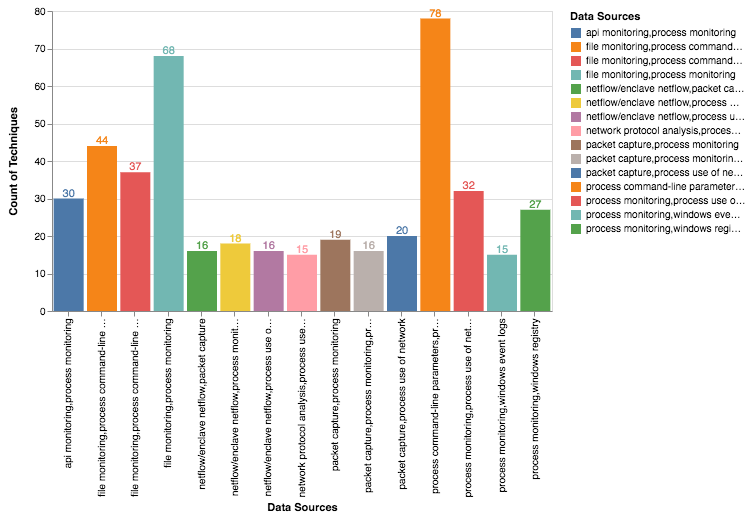

In [47]:
subsets_graph_2 = pandas.DataFrame({
    'Data Sources': list(subsets_graph.index),
    'Count of Techniques': subsets_graph['subsets_count'].tolist()})

bars = alt.Chart(subsets_graph_2).mark_bar().encode(x ='Data Sources', y ='Count of Techniques', color='Data Sources').properties(width=500)
text = bars.mark_text(align='center',baseline='middle',dx= 0,dy=-5).encode(text='Count of Techniques')
bars + text

Group (Process Monitoring - Process Command-line parameters) is the is the group of data sources with the highest number of techniques. This group of data sources are suggested to hunt 78 techniques

## 14. Let's Split all the Information About Techniques With Data Sources Defined: Matrix, Platform, Tactic and Data Source

Let's split all the relevant columns of the dataframe:

In [48]:
techniques_data = techniques_with_data_sources

attributes = ['platform','tactic','data_sources'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes:
    s = techniques_data.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_data=techniques_data.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_data", and then join "techniques_data" with "s"

# Let's re-arrange the columns from general to specific
techniques_data_2=techniques_data.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

# We are going to edit some names inside the dataframe to improve the consistency:
techniques_data_3 = techniques_data_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])

techniques_data_3.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,File monitoring
1,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Process Monitoring
2,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Process command-line parameters
3,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Windows event logs
4,mitre-attack,Windows,defense-evasion,File Permissions Modification,T1222,File monitoring


Do you remember data sources names with a reference to Windows? After splitting the dataframe by platforms, tactics and data sources, are there any macOC or linux techniques that consider windows data sources? Let's identify those rows:

In [49]:
# After splitting the rows of the dataframe, there are some values that relate windows data sources with platforms like linux and masOS.
# We need to identify those rows
conditions = [(techniques_data_3['platform']=='Linux')&(techniques_data_3['data_sources'].str.contains('windows',case=False)== True),
             (techniques_data_3['platform']=='macOS')&(techniques_data_3['data_sources'].str.contains('windows',case=False)== True),
             (techniques_data_3['platform']=='Linux')&(techniques_data_3['data_sources'].str.contains('powershell',case=False)== True),
             (techniques_data_3['platform']=='macOS')&(techniques_data_3['data_sources'].str.contains('powershell',case=False)== True),
             (techniques_data_3['platform']=='Linux')&(techniques_data_3['data_sources'].str.contains('wmi',case=False)== True),
             (techniques_data_3['platform']=='macOS')&(techniques_data_3['data_sources'].str.contains('wmi',case=False)== True)]
# In conditions we indicate a logical test

choices = ['NO OK','NO OK','NO OK','NO OK','NO OK','NO OK']
# In choices, we indicate the result when the logical test is true

techniques_data_3['Validation'] = np.select(conditions,choices,default='OK')
# We add a column "Validation" to "techniques_data_3" with the result of the logical test. The default value is going to be "OK"

What is the inconsistent data?

In [50]:
techniques_analysis_data_no_ok = techniques_data_3[techniques_data_3.Validation == 'NO OK']
# Finally, we are filtering all the values with NO OK

techniques_analysis_data_no_ok.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Validation
3,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Windows event logs,NO OK
11,mitre-attack,macOS,defense-evasion,File Permissions Modification,T1222,Windows event logs,NO OK
108,mitre-attack,Linux,lateral-movement,Exploitation of Remote Services,T1210,Windows Error Reporting,NO OK
114,mitre-attack,macOS,lateral-movement,Exploitation of Remote Services,T1210,Windows Error Reporting,NO OK
117,mitre-attack,Linux,defense-evasion,Exploitation for Defense Evasion,T1211,Windows Error Reporting,NO OK


In [51]:
print('There are ',len(techniques_analysis_data_no_ok),' rows with inconsistent data')

There are  32  rows with inconsistent data


What is the impact of this inconsistent data from a platform and data sources perspective?

In [52]:
df = techniques_with_data_sources

attributes = ['platform','data_sources']

for a in attributes:
    s = df.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    s.name = a
    df=df.drop(a, axis=1).join(s).reset_index(drop=True)
    
df_2=df.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)
df_3 = df_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])

conditions = [(df_3['data_sources'].str.contains('windows',case=False)== True),
              (df_3['data_sources'].str.contains('powershell',case=False)== True),
              (df_3['data_sources'].str.contains('wmi',case=False)== True)]

choices = ['Windows','Windows','Windows']

df_3['Validation'] = np.select(conditions,choices,default='Other')
df_3['Num_Tech'] = 1
df_4 = df_3[df_3.Validation == 'Windows']
df_5 = df_4.groupby(['data_sources','platform'])['technique'].nunique()
df_6 = df_5.to_frame().reset_index()

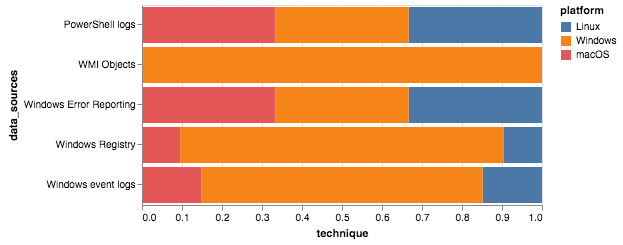

In [53]:
alt.Chart(df_6).mark_bar().encode(x=alt.X('technique', stack="normalize"),    y='data_sources',    color='platform').properties(height=200)

There are techniques that consider Windows Error Reporting, Windows Registry, and Windows event logs as data sources and they also consider platforms like Linux and masOS. We do not need to consider this rows because those data sources can only be managed at a Windows environment. These are the techniques that we should not consider in our data base:

In [54]:
techniques_analysis_data_no_ok[['technique','data_sources']].drop_duplicates().sort_values(by='data_sources',ascending=True)

,technique,data_sources
1800,Credential Dumping,PowerShell logs
108,Exploitation of Remote Services,Windows Error Reporting
117,Exploitation for Defense Evasion,Windows Error Reporting
149,Exploitation for Credential Access,Windows Error Reporting
1194,Exploitation for Privilege Escalation,Windows Error Reporting
995,Disabling Security Tools,Windows Registry
1121,Third-party Software,Windows Registry
1290,Input Capture,Windows Registry
1315,Process Injection,Windows Registry
3,File Permissions Modification,Windows event logs


Without considering this inconsistent data, the final dataframe is:

In [55]:
techniques_analysis_data_ok = techniques_data_3[techniques_data_3.Validation == 'OK']
techniques_analysis_data_ok.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Validation
0,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,File monitoring,OK
1,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Process Monitoring,OK
2,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Process command-line parameters,OK
4,mitre-attack,Windows,defense-evasion,File Permissions Modification,T1222,File monitoring,OK
5,mitre-attack,Windows,defense-evasion,File Permissions Modification,T1222,Process Monitoring,OK


In [56]:
print('There are ',len(techniques_analysis_data_ok),' rows of data that you can play with')

There are  1798  rows of data that you can play with


## 15. Getting Techniques by Data Sources

This function gets techniques' information that includes specific data sources

In [57]:
from attackcti import attack_client
lift = attack_client()

In [58]:
data_source = 'PROCESS MONITORING'

In [59]:
results = lift.get_techniques_by_datasources(data_source)

In [60]:
len(results)

157

In [61]:
data_sources_list = ['pRoceSS MoniTorinG','process commAnd-linE parameters']

In [62]:
results2 = lift.get_techniques_by_datasources(data_sources_list)

In [63]:
len(results2)

166

In [64]:
results2[1]

{'type': 'attack-pattern',
 'id': 'attack-pattern--d21a2069-23d5-4043-ad6d-64f6b644cb1a',
 'created_by_ref': 'identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5',
 'created': '2018-10-17 00:14:20.652000+00:00',
 'modified': '2018-10-31 13:45:13.024000+00:00',
 'object_marking_refs': ['marking-definition--fa42a846-8d90-4e51-bc29-71d5b4802168'],
 'url': 'https://attack.mitre.org/techniques/T1223',
 'matrix': 'mitre-attack',
 'technique': 'Compiled HTML File',
 'technique_description': 'Compiled HTML files (.chm) are commonly distributed as part of the Microsoft HTML Help system. CHM files are compressed compilations of various content such as HTML documents, images, and scripting/web related programming languages such VBA, JScript, Java, and ActiveX. (Citation: Microsoft HTML Help May 2018) CHM content is displayed using underlying components of the Internet Explorer browser (Citation: Microsoft HTML Help ActiveX) loaded by the HTML Help executable program (hh.exe). (Citation: Microsoft HTML